## MNIST
Utilizes code from crino module.

### MLP encoders and decoders

In [1]:
import numpy as np
import theano
import theano.tensor as T
import gzip, cPickle
from helpers import helpers
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 580


In [2]:
from osdfutils import crino

In [3]:
# needs local mnist.pkl.gz
mnist_f = gzip.open("mnist.pkl.gz",'rb')                              
train_set, valid_set, test_set = cPickle.load(mnist_f)                
data = train_set[0]
trgts = train_set[1]
valid = valid_set[0]
mnist_f.close()

In [4]:
%load_ext autoreload
%autoreload 2
reload(crino)

<module 'osdfutils.crino' from '/home/osendorf/proj/utils/osdfutils/crino.pyc'>

In [ ]:
epochs = 50
btsz = 100
enc_out = 2
lr = 1
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoder
enc = {
    'tag': 'enc',
    'type': crino.mlp,
    'shapes': [(28*28, 100), (100, 2*enc_out)],
    'activs': [T.tanh, crino.idty],
    'init': "normal",
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.kl_dg_g
}

# specify decoder
dec = {
    'tag': 'dec',
    'type': crino.mlp,
    'shapes': [(enc_out, 28*28)],
    'activs': [crino.idty],
    'init': "normal",
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': dec,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None

cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

settings = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = crino.momntm(params, grads, settings)
updates = crino.adadelta(params, grads, settings)
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)
print 'done.'

In [ ]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(helpers.visualize(params[0].get_value().T, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(helpers.visualize(params[-2].get_value(), 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:14*14])
im = np.array(helpers.visualize(recs, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(helpers.visualize(valid[:14*14], 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
embedder = theano.function([ims['inpt'][0]], ims['_kl_lrg_g_mu'], allow_input_downcast=True)
embs = embedder(data)

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

fig, ax = plt.subplots(1)
for cls in xrange(10):
    idx = trgts==cls
    scatter(embs[idx,0], embs[idx,1], c=colors[cls], label=str(cls), lw=0.1, alpha=0.1)

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(bbox_to_anchor=(1.05, 1), framealpha=0.2, loc=2)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
for cls in xrange(10):
    idx = trgts==cls
    ax.scatter(embs[idx,0], embs[idx,1], embs[idx,2], c=colors[cls], label=str(cls), lw=0.1, alpha=0.1)

### Linear encoder and decoder

In [ ]:
epochs = 20
btsz = 100
enc_out = 8
lr = 1
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoder
enc = {
    'tag': 'enc',
    'type': crino.mlp,
    'shapes': [(28*28, 2*enc_out)],
    'activs': [crino.idty],
    'init': "normal",
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.kl_dg_g,
}

# specify decoder
dec = {
    'tag': 'dec',
    'type': crino.mlp,
    'shapes': [(enc_out, 28*28)],
    'activs': [crino.idty],
    'init': "normal",
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': dec,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None

cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

setting = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = momntm(params, grads, **learner)
updates = crino.adadelta(params, grads, setting)
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)

In [ ]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(helpers.visualize(params[0].get_value().T, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(helpers.visualize(params[-2].get_value(), 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:14*14])
im = np.array(helpers.visualize(recs, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
embedder = theano.function([ims['inpt'][0]], ims['kl_dg_g_mu'], allow_input_downcast=True)
embs = embedder(data)

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

fig, ax = plt.subplots(1)
for cls in xrange(10):
    idx = trgts==cls
    scatter(embs[idx,0], embs[idx,1], c=colors[cls], label=str(cls), 
            lw=0.1, alpha=0.1)

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(bbox_to_anchor=(1.05, 1), framealpha=0.2, loc=2)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
for cls in xrange(10):
    idx = trgts==cls
    ax.scatter(embs[idx,2], embs[idx,0], embs[idx,1], c=colors[cls], 
               label=str(cls), lw=0.1, alpha=0.1)

## Laplacian prior

In [ ]:
epochs = 15
btsz = 100
enc_out = 3
lr = 1
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoder
enc = {
    'tag': 'enc',
    'type': crino.mlp,
    'shapes': [(28*28, 300), (300, 2*enc_out)],
    'activs': [T.tanh, crino.idty],
    'init': "normal",
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.kl_dlap_lap,
}

# specify decoder
dec = {
    'tag': 'dec',
    'type': crino.mlp,
    'shapes': [(enc_out, 300), (300, 28*28)],
    'activs': [crino.relu, crino.idty],
    'init': "normal",
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': dec,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None

cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

learner = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = momntm(params, grads, **learner)
updates = crino.adadelta(params, grads, **learner)
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)

In [ ]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(helpers.visualize(params[0].get_value().T, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(helpers.visualize(params[-2].get_value(), 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:14*14])
im = np.array(helpers.visualize(recs, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
ims.keys()

In [ ]:
embedder = theano.function([ims['inpt'][0]], ims['kl_dlap_lap_mu'], allow_input_downcast=True)
embs = embedder(data)

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

fig, ax = plt.subplots(1)
for cls in xrange(10):
    idx = trgts==cls
    scatter(embs[idx,2], embs[idx,0], 
            c=colors[cls], label=str(cls), lw=0, alpha=0.1, marker='.')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(bbox_to_anchor=(1.05, 1), framealpha=0.2, loc=2)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
for cls in xrange(10):
    idx = trgts==cls
    ax.scatter(embs[idx,2], embs[idx,0], embs[idx,1], c=colors[cls], label=str(cls), lw=0.1, alpha=0.1)

## Rank one Gaussian

In [ ]:
epochs = 15
btsz = 100
enc_out = 3
lr = 1
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoder
enc = {
    'tag': 'enc',
    'type': crino.mlp,
    'shapes': [(28*28, 300), (300, 3*enc_out)],
    'activs': [T.tanh, crino.idty],
    'init': "normal",
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.kl_lrg_g,
}

# specify decoder
dec = {
    'tag': 'dec',
    'type': crino.mlp,
    'shapes': [(enc_out, 300), (300, 28*28)],
    'activs': [crino.relu, crino.idty],
    'init': "normal",
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': dec,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None

cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

setting = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = momntm(params, grads, **learner)
updates = crino.adadelta(params, grads, setting)
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)
print 'done.'

In [ ]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(helpers.visualize(params[0].get_value(), 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:100])
im = np.array(helpers.visualize(recs, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
latent = '_kl_lrg_g_mu'
embedder = theano.function([ims['inpt'][0]], ims[latent], allow_input_downcast=True)
embs = np.zeros((data.shape[0], enc_out))
for mbi in xrange(batches):
    embs[mbi*btsz:(mbi+1)*btsz]= embedder(data[mbi*btsz:(mbi+1)*btsz])

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

fig, ax = plt.subplots(1)
for cls in xrange(10):
    idx = trgts==cls
    scatter(embs[idx,0], embs[idx,1], 
            c=colors[cls], label=str(cls), lw=0, alpha=0.4, marker='.')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(bbox_to_anchor=(1.05, 1), framealpha=0.2, loc=2)

## Convolutional Network 1
Using a convolutional network as descriminative model.

In [ ]:
epochs = 50
btsz = 100
dx, dy = 28, 28
enc_out = 2
lr = 1.
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoder
cnn = {
    'tag': 'cnn',
    'type': crino.conv,
    'shapes': [(20, 1, 5, 5), (50, 20, 5, 5)],
    'activs': [crino.relu, crino.relu],
    'pools': [(2, 2), (2, 2)],
    'imshape': (btsz, 1, dx, dy),
    'init': "normal"
}

mlp = {
    'tag': 'mlp',
    'type': crino.mlp,
    'shapes': [(50*4*4, 100), (100, 3*enc_out)],
    'activs': [crino.relu, crino.idty],
    'init': "normal",
}

enc = {
    'tag': 'enc',
    'type': crino.sequential,
    'components': [cnn, mlp] 
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.kl_lrg_g,
}
latent = "kl_dg_g_mu"

# specify decoder
dec = {
    'tag': 'dec',
    'type': crino.mlp,
    'shapes': [(enc_out, 300), (300, 28*28)],
    'activs': [T.tanh, crino.idty],
    'init': "normal",
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': dec,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None

cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

learner = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = momntm(params, grads, **learner)
updates = crino.adadelta(params, grads, learner)
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)
print 'done.'

In [ ]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(helpers.visualize(params[-2].get_value(), 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:100])
im = np.array(helpers.visualize(recs, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
latent='_kl_lrg_g_mu'
embedder = theano.function([ims['inpt'][0]], ims[latent], allow_input_downcast=True)
embs = np.zeros((data.shape[0], enc_out))
for mbi in xrange(batches):
    embs[mbi*btsz:(mbi+1)*btsz]= embedder(data[mbi*btsz:(mbi+1)*btsz])

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

fig, ax = plt.subplots(1)
for cls in xrange(10):
    idx = trgts==cls
    scatter(embs[idx,0], embs[idx,1], 
            c=colors[cls], label=str(cls), lw=0, alpha=0.05, marker='.')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(bbox_to_anchor=(1.05, 1), framealpha=0.2, loc=2)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
for cls in xrange(10):
    idx = trgts==cls
    ax.scatter(embs[idx,2], embs[idx,0], embs[idx,1], c=colors[cls], label=str(cls), lw=0.1, alpha=0.1)

## CNN 2
Convolutional layers in encoder and decoder.

In [98]:
reload(crino)
epochs = 50
btsz = 100
dx, dy = 28, 28
enc_out = 2
lr = 1.
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoder
cnn = {
    'tag': 'cnn',
    'type': crino.conv,
    'shapes': [(20, 1, 5, 5), (50, 20, 5, 5)],
    'activs': [crino.relu, crino.relu],
    'pools': [(2, 2), (2, 2)],
    'imshape': (btsz, 1, dx, dy),
    'inits': [{"type":"msft",}]*2 
}

mlp = {
    'tag': 'mlp',
    'type': crino.mlp,
    'shapes': [(50*4*4, 100), (100, 2*enc_out)],
    'activs': [crino.relu, crino.idty],
    'init': "normal",
}

enc = {
    'tag': 'enc',
    'type': crino.sequential,
    'components': [cnn, mlp] 
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.kl_dg_g,
}
latent = "kl_dg_g_mu"

# specify decoder
mlp2 = {
    'tag': 'mlp',
    'type': crino.mlp,
    'shapes': [(enc_out, 100), (100, 50*4*4)],
    'activs': [crino.relu, crino.idty],
    'init': "normal",
}

cnn2 = {
    'tag': 'dcnn',
    'type': crino.deconv,
    'shapes': [(50, 50, 5, 5), (50, 50, 5, 5), (20, 50, 5, 5), (1, 20, 1, 1)],
    'activs': [crino.relu, crino.relu, crino.relu, crino.idty],
    'borders': ["full", "full", "valid", "valid"],
    'scales': [2, 2, 2, 1],
    'imshape': (btsz, 50, 4, 4),
    'inits': [{"type":"msft",}]*3 + [{"type": "normal"}]
}

dec = {
    'tag': 'dec',
    'type': crino.sequential,
    'components': [mlp2, cnn2] 
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': dec,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None

cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

learner = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = momntm(params, grads, **learner)
updates = crino.adadelta(params, grads, learner)
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)

Variational AE
Epochs 50
Batches per epoch 500

[SEQ -- enc] Sequential with 2 subcomponents.
[SEQ -- enc] Input is inpt.
[CNN -- enc|cnn]: CNN with 2 layers, input image (100, 1, 28, 28).
[CNN -- enc|cnn]: Input is a 1-list, taking first element.
[MLP -- enc|mlp]: MLP with 2 layers.
[SEQ -- dec] Sequential with 2 subcomponents.
[SEQ -- dec] Input is _kl_dg_g_z.
[MLP -- dec|mlp]: MLP with 2 layers.
[DCNN -- dec|dcnn]: DeconvCNN with 4 layers, input image (100, 50, 4, 4).
[DCNN -- dec|dcnn, L0]: Slicing in 2d with 2.
---- (100, 50, 8, 8)
[DCNN -- dec|dcnn, L1]: Slicing in 2d with 2.
---- (100, 50, 16, 16)
---- (100, 20, 28, 28)
---- (100, 1, 28, 28)
[BERNXE]: Target is a 1-list, taking first element.
[AdaDELTA] lr: 1.0; decay: 0.95


In [104]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

0 150.055143646
1 148.816049896
2 147.754572632
3 146.995486023
4 146.245921753
5 145.693559128
6 145.047895554
7 144.610533356
8 144.246890381


KeyboardInterrupt: 

In [79]:
im = np.array(helpers.visualize(params[-2].get_value().flatten(2).reshape(20, 25), 5*5, fill=255))
plt.imshow(im, cmap=cm.gray)

ValueError: total size of new array must be unchanged

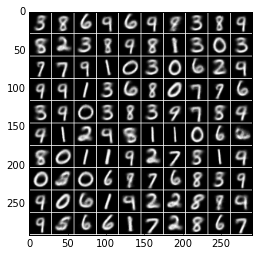

In [105]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:100])
im = np.array(helpers.visualize(recs, 28*28, fill=255))
plt.imshow(im, cmap=cm.gray)

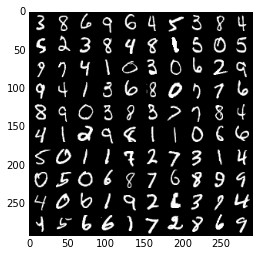

In [101]:
im = np.array(helpers.visualize(valid[:100], 28*28))
plt.imshow(im, cmap=cm.gray)

In [102]:
latent = '_kl_dg_g_mu'
embedder = theano.function([ims['inpt'][0]], ims[latent], allow_input_downcast=True)
embs = np.zeros((data.shape[0], enc_out))
for mbi in xrange(batches):
    embs[mbi*btsz:(mbi+1)*btsz]= embedder(data[mbi*btsz:(mbi+1)*btsz])

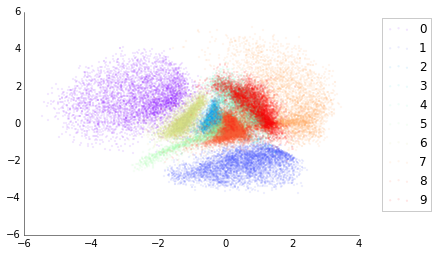

In [106]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

fig, ax = plt.subplots(1)
for cls in xrange(10):
    idx = trgts==cls
    plt.scatter(embs[idx,0], embs[idx,1], 
            c=colors[cls], label=str(cls), lw=0, alpha=0.1, marker='.')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(bbox_to_anchor=(1.05, 1), framealpha=0.2, loc=2)

## Bilinear generative model

In [ ]:
epochs = 50
btsz = 100
#enc_out = 2 #don't use in this case, check by hand!
lr = 1
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoder
enc = {
    'tag': 'enc',
    'type': crino.mlp,
    'shapes': [(28*28, 300), (300, 2*50 + 2 * 25)],
    'activs': [crino.relu, crino.idty],
    'init': "normal",
}

kldg = {
    'type': crino.kl_dg_g,
    'units': 50,
    'suff': 2,
}

kldl = {
    'type': crino.kl_dlap_lap,
    'units':25,
    'suff': 2,
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.multi_kl,
    'kls': [kldg, kldl]
}

# specify decoder
bl2 = {
    'tag': 'dec',
    'type': crino.dblin,
    'theta': (50, 200),
    'psi': (25, 200),
    #'dactiv': T.exp,
    'pactiv': crino.idty,
    'tactiv': crino.idty,
    'activ': crino.idty,
    'phi': (200, 5*32*32),
    'init': {'theta': "normal", 'psi': "normal", 'phi': "normal"},
    'normalize': {'psi': 1, 'phi': 0}
}

cnn2 = {
    'tag': 'cnn',
    'type': crino.conv,
    'shapes': [(1, 5, 5, 5)],
    'activs': [crino.idty],
    'pools': [(1, 1)],
    'imshape': (btsz, 5, 32, 32),
    'init': "normal"
}

bl = {
    'tag': 'dec',
    'type': crino.dblin,
    'theta': (50, 300),
    'psi': (25, 300),
    #'dactiv': T.exp,
    'pactiv': crino.idty,
    'tactiv': crino.idty,
    'activ': crino.relu,
    'phi': (300, 28*28),
    'init': {'theta': "normal", 'psi': "normal", 'phi': "normal"},
    'normalize': {'psi': 0, 'phi': 1}
}

dec = {
    'tag': 'dec',
    'type': crino.sequential,
    'components': [bl2, cnn2] 
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': bl,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None

cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

settings = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = crino.momntm(params, grads, **learner)
updates = crino.adadelta(params, grads, settings, **ims['normalize'])
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)

In [ ]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(helpers.visualize(params[0].get_value().T, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(helpers.visualize(params[-2].get_value(), 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:10*10])
im = np.array(helpers.visualize(recs, 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(helpers.visualize(valid[:10*10], 28*28))
imshow(im, cmap=cm.gray)

In [ ]:
ims.keys()

In [ ]:
embedder = theano.function([ims['inpt'][0]], ims['multikl-1_kl_dg_g_mu'], allow_input_downcast=True)
embs = embedder(data)

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

fig, ax = plt.subplots(1)
for cls in xrange(10):
    idx = trgts==cls
    scatter(embs[idx,0], embs[idx,2], 
            c=colors[cls], label=str(cls), lw=0, alpha=0.1, marker='.')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.legend(bbox_to_anchor=(1.05, 1), framealpha=0.2, loc=2)

In [ ]:
N=10
fig, axes = plt.subplots(N, N)
spines = ['top', 'right', 'bottom', 'left']

for i in range(N):
    for j in range(N):
        axes[i, j].xaxis.set_visible(False)
        axes[i, j].yaxis.set_visible(False)
        if i==j:
            axes[i,j].hist(embs[:, i], 25)
        else:
            for cls in xrange(10):
                idx = trgts==cls
                axes[i, j].scatter(embs[idx, i], embs[idx, j], color=colors[cls], lw=0.1, marker='.', alpha=0.1)

## Product MLP as encoder

In [ ]:
epochs = 50
btsz = 100
enc_out = 8
lr = 1e-3
momentum = 0.9
decay = 0.95
batches = data.shape[0]/btsz
print "Variational AE"
print "Epochs", epochs
print "Batches per epoch", batches
print

# specify encoderp
pmlp= {
    'tag': 'enc',
    'type': crino.pmlp,
    'shapes': [(28*28, 500, 200), (200, 100, 100)],
    'activs': [crino.relu, crino.relu],
    'noises': [("gauss", 0.1), ("gauss", 0.1)],
    'init': "normal",
}

mlp= {
    'tag': 'enc',
    'type': crino.mlp,
    'shapes': [(100, 2*enc_out)],
    'activs': [crino.idty],
    'init': "normal",
}

enc = {
    'tag': 'enc',
    'type': crino.sequential,
    'components': [pmlp, mlp] 
}

# specify cost for variational approx.
kl_cost = {
    'type': crino.kl_dg_g,
}

# specify decoder
dec = {
    'tag': 'dec',
    'type': crino.mlp,
    'shapes': [(enc_out, 100), (100, 28*28)],
    'activs': [T.tanh, crino.idty],
    'init': "normal",
}

# specify generative cost
cost = {
    'type': crino.bern_xe,
}

# finale model
vae = {
    'encoder': enc,
    'decoder': dec,
    'kl': kl_cost,
    'cost': cost
}

# tie first layer of encoder with last layer of decoder
tied = None
cost, params, ims = crino.vae(config=vae, special=None, tied=tied)
grads = T.grad(cost, params)

settings = {"lr": lr, "momentum": momentum, "decay": decay}
#updates = crino.momntm(params, grads, **learner)
updates = crino.rmsprop(params, grads, settings, **ims['normalize'])
train = theano.function([ims['inpt'][0]], cost, 
                        updates=updates, allow_input_downcast=True)
print 'done.'

In [ ]:
print "Binarize data -- For comparision, check Hugo Larochelles dataset."
data = 1.0*(np.random.uniform(size=data.shape) < data)

In [ ]:
sz = data.shape[0]
for epoch in xrange(epochs):
    cost = 0
    for mbi in xrange(batches):
        cost += btsz*train(data[mbi*btsz:(mbi+1)*btsz])
    print epoch, cost/sz

In [ ]:
im = np.array(helpers.visualize(params[0].get_value().T, 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
im = np.array(helpers.visualize(params[-2].get_value(), 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
reconstructor = theano.function([ims['inpt'][0]], ims['predict'], allow_input_downcast=True)
recs = reconstructor(valid[:10*10])
im = np.array(helpers.visualize(recs, 28*28))
plt.imshow(im, cmap=cm.gray)

In [ ]:
def estimate_lkh(data, no_mcs, inpts, z_samples, ncll_x_z, params, pz, prior):
    z_smpls = theano.function([inpts], z_samples, allow_input_downcast=True)
    params = theano.function([inpts], params, allow_input_downcast=True)
    ncll_x_z = theano.function([inpts, z_samples], ncll_x_z, allow_input_downcast=True)
    mc_ll = np.zeros((no_mcs, data.shape[0]))
    for i in xrange(no_mcs):
        zs = z_smpls(data)
        pars = params(data)
        ll_z_x = pz(zs, *pars).sum(axis=1)
        ll_z = pz(zs, *prior).sum(axis=1)
        ll_x_z = -ncll_x_z(data, zs).sum(axis=1)
        ll_xz = ll_x_z + ll_z - ll_z_x
        mc_ll[i, :] = ll_xz
    ll = logsumexp(mc_ll, axis=0) - np.log(no_mcs)
    #ll = np.exp(ll).mean()
    return ll.mean()

In [ ]:
def logsumexp(array, axis):
    """
    Compute log of (sum of exps) 
    along _axis_ in _array_ in a 
    stable way. _array_ is in the log domain.

    If _axis_ is not zero, caller must transform
    result in suitable shape.
    """
    arr = np.rollaxis(array, axis)
    axis_max = np.max(arr, axis=0)
    return axis_max + np.log(np.sum(np.exp(arr - axis_max), axis=0))

In [ ]:
def ll_diag_gauss_logvar(x, mu, logvar):
    const = -np.log(2*np.pi)/2
    return const -logvar/2 - (x - mu)**2 / (2 * np.exp(logvar))

In [ ]:
ims

In [ ]:
reload(crino)
params = [ims['_kl_dg_g_mu'], ims['_kl_dg_g_log_var']]
res = crino.estimate_lkh(data[:100], 1000, ims['inpt'][0], ims['_kl_dg_g_z'], ims['neg_log_like_per_sampel'], params, ll_diag_gauss_logvar, [0., 0.])